In [1]:
import starepandas
import geopandas
import pandas
import datetime
import matplotlib.pyplot as plt

# Loading Some Data

In [2]:
cities = ['Buenos Aires', 'Brasilia', 'Santiago', 
          'Bogota', 'Caracas', 'Sao Paulo', 'Bridgetown']

latitudes = [-34.58, -15.78, -33.45, 4.60, 10.48, -23.55, 13.1]
longitudes = [-58.66, -47.91, -70.66, -74.08, -66.86, -46.63, -59.62]
data =  {'City': cities, 
         'Latitude': latitudes, 'Longitude': longitudes}

cities = starepandas.STAREDataFrame(data)
stare = starepandas.sids_from_xy(cities.Longitude, cities.Latitude, level=26)
geom = geopandas.points_from_xy(cities.Longitude, cities.Latitude, crs='EPSG:4326')
cities.set_sids(stare, inplace=True)
cities.set_geometry(geom, inplace=True)
cities.add_trixels(inplace=True)

In [6]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))#.set_crs(4326)
samerica = countries[countries.continent=='South America']
samerica = starepandas.STAREDataFrame(samerica, add_sids=True, level=7, add_trixels=True)

brazil = samerica[samerica.name=='Brazil']

# Small Join

In [8]:
geopandas.sjoin(samerica, cities, how='left').head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,sids_left,trixels_left,index_right,City,Latitude,Longitude,sids_right,trixels_right
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...","[1831874332805038087, 1831909517177126919, 183...","MULTIPOLYGON (((-68.10744 -55.31801, -67.97225...",0.0,Buenos Aires,-34.58,-58.66,2.663379e+18,"POLYGON ((-58.66000 -34.58000, -58.66000 -34.5..."
10,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...","[1822268999224786951, 1822339367968964615, 182...","MULTIPOLYGON (((-70.49911 -54.87622, -70.66819...",2.0,Santiago,-33.45,-70.66,2.723775e+18,"POLYGON ((-70.66000 -33.45000, -70.66000 -33.4..."
20,2931,South America,Falkland Is.,FLK,281.8,"POLYGON ((-61.20000 -51.85000, -60.00000 -51.2...","[1807104534854500359, 1807245272342855687, 180...","MULTIPOLYGON (((-60.67409 -51.68503, -59.57634...",NaN,NaN,NaN,NaN,NaN,None
28,3360148,South America,Uruguay,URY,73250.0,"POLYGON ((-57.62513 -30.21629, -56.97603 -30.1...","[2632353982198054918, 2661627379775963142, 266...","MULTIPOLYGON (((-55.17662 -32.24790, -55.77960...",NaN,NaN,NaN,NaN,NaN,None
29,207353391,South America,Brazil,BRA,3081000.0,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...","[2749447572509687812, 2796735368597078020, 286...","MULTIPOLYGON (((-53.69934 -4.63080, -61.44765 ...",1.0,Brasilia,-15.78,-47.91,2.867415e+18,"POLYGON ((-47.91000 -15.78000, -47.91000 -15.7..."


In [9]:
starepandas.stare_join(samerica, cities, how='left').head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry_left,sids_left,trixels_left,key_right,City,Latitude,Longitude,sids_right,geometry_right,trixels_right
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...","[1811572950109782022, 1811713687598137351, 181...","MULTIPOLYGON (((-68.10744 -55.31801, -67.97225...",0.0,Buenos Aires,-34.58,-58.66,2.663379e+18,POINT (-58.66000 -34.58000),"POLYGON ((-58.66000 -34.58000, -58.66000 -34.5..."
10,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...","[1810517418947117063, 1810622972063383559, 181...","MULTIPOLYGON (((-70.49911 -54.87622, -70.66819...",2.0,Santiago,-33.45,-70.66,2.723775e+18,POINT (-70.66000 -33.45000),"POLYGON ((-70.66000 -33.45000, -70.66000 -33.4..."
20,2931,South America,Falkland Is.,FLK,281.8,"POLYGON ((-61.20000 -51.85000, -60.00000 -51.2...","[1807104534854500359, 1807245272342855687, 180...","MULTIPOLYGON (((-60.67409 -51.68503, -59.57634...",NaN,NaN,NaN,NaN,NaN,None,None
28,3360148,South America,Uruguay,URY,73250.0,"POLYGON ((-57.62513 -30.21629, -56.97603 -30.1...","[2632353982198054918, 2632494719686410247, 263...","MULTIPOLYGON (((-55.17662 -32.24790, -55.77960...",NaN,NaN,NaN,NaN,NaN,None,None
29,207353391,South America,Brazil,BRA,3081000.0,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...","[2643648165638569991, 2643753718754836487, 264...","MULTIPOLYGON (((-53.69934 -4.63080, -61.44765 ...",1.0,Brasilia,-15.78,-47.91,2.867415e+18,POINT (-47.91000 -15.78000),"POLYGON ((-47.91000 -15.78000, -47.91000 -15.7..."


# Granule Intersect

In [10]:
fname = '../tests/data/granules/MYD05_L2.A2020060.1635.061.2020061153519.hdf'

In [11]:
modis = starepandas.read_granule(fname, add_sids=True, adapt_resolution=True, track_first=False)

trixels = modis.make_trixels()
modis.set_trixels(trixels, inplace=True)

geom = geopandas.points_from_xy(modis.lon, modis.lat, crs='EPSG:4326')
modis.set_geometry(geom, inplace=True)

## Geos based intersects test

In [12]:
start = datetime.datetime.now()
b = modis.intersects(brazil.iloc[0].geometry)
print(datetime.datetime.now() - start)

0:00:02.177695


## STARE based intersects test

In [14]:
start = datetime.datetime.now()
a = modis.stare_intersects(brazil['sids'].iloc[0])
print(datetime.datetime.now() - start)

0:00:00.151249


# Plot

<AxesSubplot:>

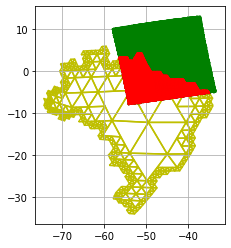

In [15]:
fig, ax = plt.subplots()
ax.grid(True)

brazil.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=0)
#brazil.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)
modis.plot(ax=ax, color='green', zorder=2)
modis[a].plot(ax=ax, color='red', trixels=True, zorder=3)

# Now doing Join

In [16]:
joined = starepandas.stare_join(modis, samerica, how='left')

In [20]:
joined.head()

,lat,lon,sids_left,Scan_Start_Time,Solar_Zenith,Solar_Azimuth,Sensor_Zenith,Sensor_Azimuth,Water_Vapor_Infrared,trixels_left,geometry_left,key_right,pop_est,continent,name,iso_a3,gdp_md_est,geometry_right,sids_right,trixels_right
0,-4.923621,-33.579193,2833105768974759241,8.571477e+08,31.989999,-96.479998,65.169999,-99.029998,NaN,"POLYGON ((-33.74330 -4.97737, -33.50112 -4.989...",POINT (-33.57919 -4.92362),NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
1,-4.956750,-33.786446,2833110603003551593,8.571477e+08,31.779999,-96.449998,64.559999,-99.009998,NaN,"POLYGON ((-33.88021 -4.75337, -33.98547 -4.965...",POINT (-33.78645 -4.95675),NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
2,-4.988602,-33.986107,2833112722354712041,8.571477e+08,31.579999,-96.419998,63.949999,-98.989998,5.392,"POLYGON ((-34.09081 -5.17770, -33.84856 -5.189...",POINT (-33.98611 -4.98860),NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
3,-5.019270,-34.178722,2833084363820531337,8.571477e+08,31.389999,-96.389998,63.349999,-98.969998,5.532,"POLYGON ((-34.09081 -5.17770, -33.98547 -4.965...",POINT (-34.17872 -5.01927),NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
4,-5.048833,-34.364750,2833230005031123593,8.571477e+08,31.199999,-96.359998,62.749999,-98.949998,5.304,"POLYGON ((-34.33319 -5.16576, -34.22763 -4.953...",POINT (-34.36475 -5.04883),NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None


In [18]:
joined = geopandas.GeoDataFrame(joined).set_geometry('trixels_left')

<AxesSubplot:>

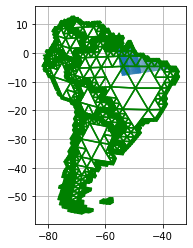

In [19]:
fig, ax = plt.subplots()
ax.grid(True)

#ax.set_ylim(-10, 10)
#ax.set_xlim(-60, -30)
samerica.plot(ax=ax, color='green')
joined.plot(ax=ax, column='name')

In [21]:
joined.head()

,lat,lon,sids_left,Scan_Start_Time,Solar_Zenith,Solar_Azimuth,Sensor_Zenith,Sensor_Azimuth,Water_Vapor_Infrared,trixels_left,geometry_left,key_right,pop_est,continent,name,iso_a3,gdp_md_est,geometry_right,sids_right,trixels_right
0,-4.923621,-33.579193,2833105768974759241,8.571477e+08,31.989999,-96.479998,65.169999,-99.029998,NaN,"POLYGON ((-33.74330 -4.97737, -33.50112 -4.989...",POINT (-33.57919 -4.92362),NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
1,-4.956750,-33.786446,2833110603003551593,8.571477e+08,31.779999,-96.449998,64.559999,-99.009998,NaN,"POLYGON ((-33.88021 -4.75337, -33.98547 -4.965...",POINT (-33.78645 -4.95675),NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
2,-4.988602,-33.986107,2833112722354712041,8.571477e+08,31.579999,-96.419998,63.949999,-98.989998,5.392,"POLYGON ((-34.09081 -5.17770, -33.84856 -5.189...",POINT (-33.98611 -4.98860),NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
3,-5.019270,-34.178722,2833084363820531337,8.571477e+08,31.389999,-96.389998,63.349999,-98.969998,5.532,"POLYGON ((-34.09081 -5.17770, -33.98547 -4.965...",POINT (-34.17872 -5.01927),NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
4,-5.048833,-34.364750,2833230005031123593,8.571477e+08,31.199999,-96.359998,62.749999,-98.949998,5.304,"POLYGON ((-34.33319 -5.16576, -34.22763 -4.953...",POINT (-34.36475 -5.04883),NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None
